# *pyfabric example 03: trabecular bone fabric tensor; multi-resolution*
Fabric tensor of trabecular bone of the proximal femur - comparison of scans with different spatial resolution

Created on:  25.10.2021 <br />
Last update: 09.04.2024 <br />

- By: [Gianluca Iori](https://github.com/gianthk), 2024
- Data source: QCT and HR-pQCT datasets were collected within the ANR-DFG TaCoSound project.
- Code license: MIT
- Narrative license: CC-BY-NC-SA

---
## Aims
1. Load and inspect QCT and HR-pQCT datasets of the proximal femur using simpleITK
2. detect alignment cement markers on both images
3. compute transformation matrices for QCT to HR-pQCT image registration
4. apply 3D affine registration transformation to register QCT data to HR-pQCT
5. load mask of whole bone and of trabecular bone
6. compute trabecular core mesh; find centroids of anisotropy analysis
7. crop cube portions of trabecular bone and save as separate .MHA or stack of TIFFs

---
## Configuration and imports

In [16]:
import os
import sys
sys.path.append('/home/gianthk/PycharmProjects/pyfabric')
sys.path.append('/home/gianthk/PycharmProjects/BEATS/recon_utils')

# work_folder = '/media/gianthk/My Passport'
work_folder = '/home/gianthk'

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.filters import threshold_multiotsu
from skimage import morphology
from skimage.measure import label, regionprops, regionprops_table
import pandas as pd
import SimpleITK as sitk
import pyfabric

In [17]:
from recon_utils import plot_midplanes

In [4]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 6}

plt.rc('font', **font)

In [5]:
%%html
<style>
table {float:left}
</style>

## Functions definition

In [12]:
def dist_table(coors):
    n_points = coors.shape[0]
    disttab = np.zeros([n_points, n_points])
    for i in range(n_points):
        for j in range(n_points):
            disttab[i,j] = np.linalg.norm(coors[i,:]-coors[j,:])
    return disttab

In [13]:
def markers_coors(BWimage):
    # get coordinates of 5 cement markers from binary image
    
    label_img = label(BWimage)
    
    props = regionprops_table(label_img, properties=('centroid','area'))
    
    props_df = pd.DataFrame(props)
    
    props_df.sort_values('area', ascending=False, inplace=True)
    props_df.reset_index(drop=True, inplace=True)
    
    markers_df = props_df[1:6]
    centroids = markers_df[['centroid-0', 'centroid-1', 'centroid-2']].to_numpy()
    
    distances = dist_table(centroids)
    
    for row in distances:
        row.sort()
        
    sum2dist = np.sum(distances[:,0:3], axis=1).tolist()
    min_3_dists = heapq.nsmallest(3,sum2dist)
    
    count = 0
    marker_id = np.zeros(3)
    for dist in min_3_dists:
        marker_id[count] = sum2dist.index(dist)
        count = count + 1

    M5_id = int(marker_id[0])
    M1_id = int(marker_id[1])
    M2_id = int(marker_id[2])
    
    
    sum3dist = np.sum(distances[:,0:4], axis=1).tolist()
    max_2_dists = heapq.nlargest(2,sum3dist)

    count = 0
    marker_id = np.zeros(2)
    for dist in max_2_dists:
        marker_id[count] = sum3dist.index(dist)
        count = count + 1

    M3_id = int(marker_id[0])
    M4_id = int(marker_id[1])
    
    marker_coors = np.zeros([5,3])
    marker_coors[0,:] = centroids[M1_id,:]
    marker_coors[1,:] = centroids[M2_id,:]
    marker_coors[2,:] = centroids[M3_id,:]
    marker_coors[3,:] = centroids[M4_id,:]
    marker_coors[4,:] = centroids[M5_id,:]
    
    return marker_coors

In [14]:
def vectors2rotation3Dmatrix(a,b):
    # VECTORS2ROTATION3DMATRIX rotation matrix R that rotates vector a onto vector b
    #    R = vectors2rotation3Dmatrix(a, b)
    #    Returns 3x3 rotation matrix that transforms vector a into vector b.

    #  Example: rotate (clockwise) vector of 90deg around Z-axis.
    #    R = vectors2rotation3Dmatrix([0 1 0], [1 0 0]);
    #    R*[1; 0; 4]
    #    ans =
    #            0
    #            -1
    #            4

    #    See: http://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d
    #    ______________________________________________________

    #    Author:         Gianluca Iori (gianthk.iori@gmail.com)
    #    BSRT - Charite Berlin
    #    Created on:   01/01/2016
    #    Last update:  19/04/2016

    #    See also CROSS, DOT, NORM, EYE.

    #    this class is part of the synchro toolbox
    #    ______________________________________________________

    a = a/np.linalg.norm(a);
    b = b/np.linalg.norm(b);

    v = np.cross(a,b);
    s = np.linalg.norm(v);
    c = np.dot(a,b);
    skewv = [[0, -v[2], v[1]],
             [v[2], 0, -v[0]],
             [-v[1], v[0], 0]]

    R = np.eye(3) + skewv + np.matmul(skewv, skewv)*((1 - c)/(s**2));
#     return skewv
    return R

In [15]:
def align_with_XYplane(n12, n14):
    # return affine rotation matrix aligning the plane defined by vectors n12 and n14 with the X-Y plane
    angle_n12_n14 = np.arctan2(np.linalg.norm(np.cross(n12,n14)),np.dot(n12,n14))
    print('Angle between n12 and n14:', abs(angle_n12_n14/np.pi*180), 'deg')
    
    # Allign n12 with -X versor and n14 with +Y versor
    R_n12_x = vectors2rotation3Dmatrix(n12, [-1, 0, 0])
    n12_1 = np.matmul(R_n12_x, n12)
    n14_1 = np.matmul(R_n12_x, n14)
    
    R_n14_1_y = vectors2rotation3Dmatrix(n14_1, [0, 1, 0])
    n12_2 = np.matmul(R_n14_1_y, n12_1)
    n14_2 = np.matmul(R_n14_1_y, n14_1)
    
    return np.matmul(R_n14_1_y, R_n12_x)

In [16]:
def align_with_vectors(n12, n14, v12, v14):
    # return affine rotation matrix aligning the plane defined by vectors n12 and n14 with the plane defined by vectors v12 and v14 
    angle_n12_n14 = np.arctan2(np.linalg.norm(np.cross(n12,n14)),np.dot(n12,n14))
    print('Angle between n12 and n14:', abs(angle_n12_n14/np.pi*180), 'deg')
    
    angle_v12_v14 = np.arctan2(np.linalg.norm(np.cross(v12,v14)),np.dot(v12,v14))
    print('Angle between v12 and v14:', abs(angle_v12_v14/np.pi*180), 'deg')
    
    # Allign n12 with v12 versor and n14 with v14 versor
    R_n12_v12 = vectors2rotation3Dmatrix(n12, v12)
    n12_1 = np.matmul(R_n12_v12, n12)
    n14_1 = np.matmul(R_n12_v12, n14)
    
    R_n14_1_v14 = vectors2rotation3Dmatrix(n14_1, v14)
    n12_2 = np.matmul(R_n14_1_v14, n12_1)
    n14_2 = np.matmul(R_n14_1_v14, n14_1)
    
    return np.matmul(R_n14_1_v14, R_n12_v12)

In [66]:
def resample(image, transform):
    # Output image Origin, Spacing, Size, Direction are taken from the reference
    # image in this call to Resample
    reference_image = image
    interpolator = sitk.sitkCosineWindowedSinc
    default_value = 100.0
    
    return sitk.Resample(image, reference_image, transform, interpolator, default_value)

In [74]:
def affine_trans(image, transform, tmatrix, verbose=False):
    new_transform = sitk.AffineTransform(transform)
    matrix = np.array(transform.GetMatrix()).reshape((dimension,dimension))
    matrix = tmatrix
    if verbose:
        print(matrix)
    new_transform.SetMatrix(matrix.ravel())
    new_transform.SetInverse()
    new_transform.SetCenter(np.array(image.GetSize())/2 * image.GetSpacing())
    resampled = resample(image, new_transform)
    
    return resampled

## Computational workflow
### Read and inspect input data

In [10]:
# input_file_HR = work_folder + '/Data/TacoSound/XtremeCT-II/00_resampled_data/2019_L/C0001524.mhd'
input_dir_QCT_DCM = '/home/gianthk/Data/TacoSound/QCTFEMUR_1955L_new/QCTFEMUR_1955L/Q_CT_DIAGBILANZ_HR_0003'
# input_file_QCT = work_folder + '/Data/TacoSound/QCT/QCTFEMUR_2019L/slices/slice_0000.tif'

In [13]:
# read QCT dataset
reader = sitk.ImageSeriesReader()

dicom_names = reader.GetGDCMSeriesFileNames(input_dir_QCT_DCM)
reader.SetFileNames(dicom_names)

data_3D_QCT = reader.Execute()

ImageSeriesReader (0x32c9600): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.594295



In [12]:
size = data_3D_QCT.GetSize()
print("Image size:", size[0], size[1], size[2])
spac = data_3D_QCT.GetSpacing() # it's a tuple
print("Image spacing:", spac[0], spac[1], spac[2])

Image size: 512 512 632
Image spacing: 0.29296875 0.29296875 0.30570522979397796


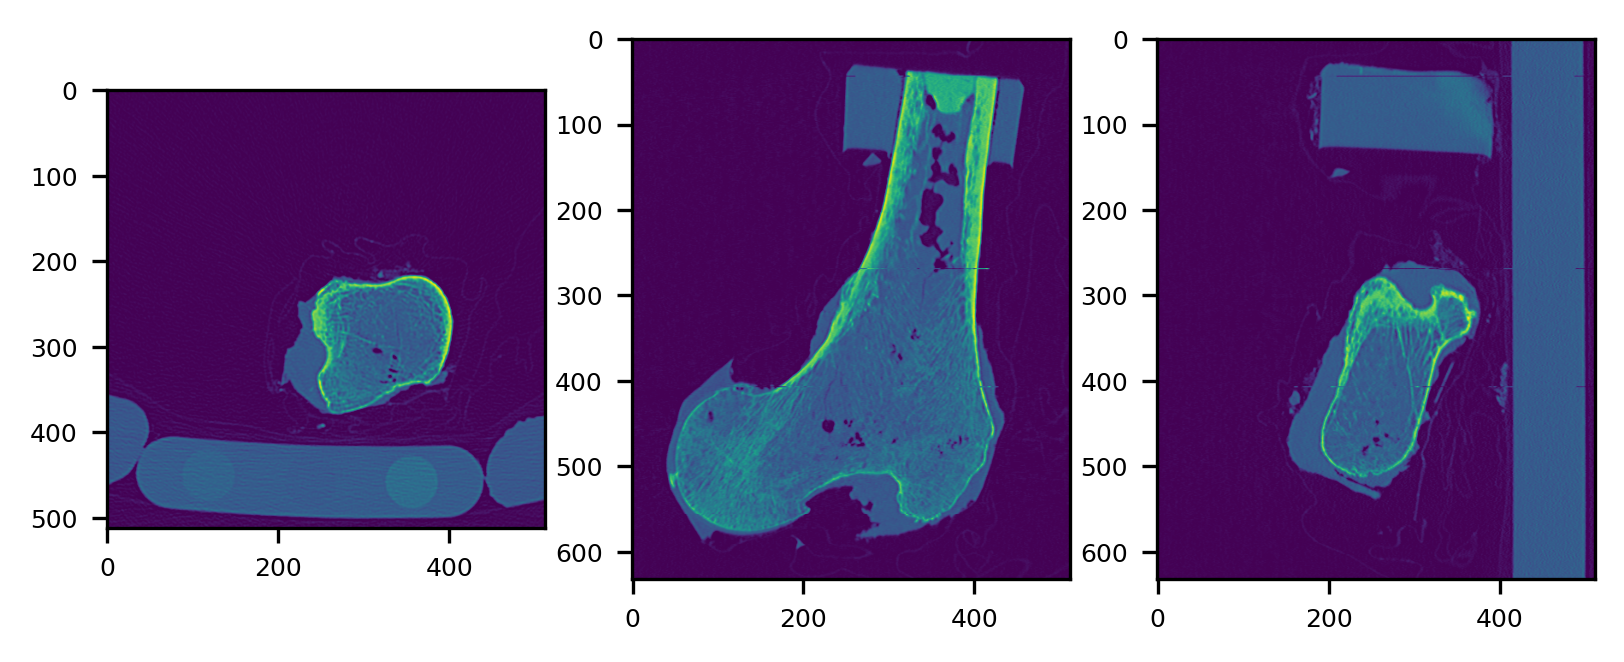

In [19]:
# Inspect dataset
plot_midplanes(sitk.GetArrayFromImage(data_3D_QCT))
plt.show()

Inspect the dataset with [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets)

In [86]:
data_3D = io.imread(input_file_HR, plugin='simpleitk')
vs = [0.303, 0.303, 0.303] # [Z, Y, X][mm]

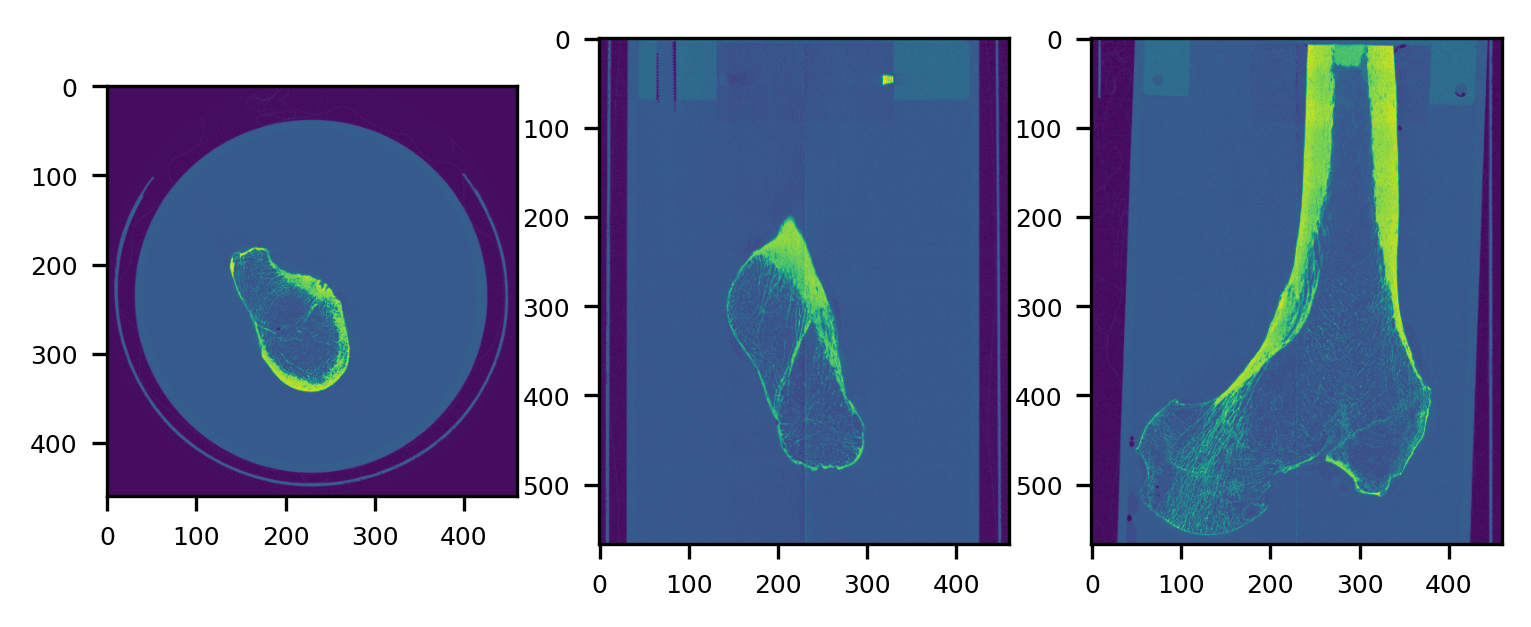

In [10]:
# Inspect dataset
ru.plot_midplanes(data_3D)
plt.show()

### Find cement markers
#### Segment markers and bone with multi otsu threshold
Multi-Otsu threshold of QCT dataset: 3 materials (backgroud, water, bone)

In [11]:
ts = threshold_multiotsu(data_3D_QCT)
print(ts)

[ 557 1798]


We add an image opening step to remove spurious voxels

In [ ]:
data_3D_QCT_BW = morphology.binary_opening(data_3D_QCT > ts[1])

High resolution dataset:

In [13]:
ts_HR = threshold_multiotsu(data_3D)
print(ts_HR)

[1018 3860]


In [ ]:
data_3D_BW = morphology.binary_opening(data_3D[0:90, :, :] > ts_HR[1])

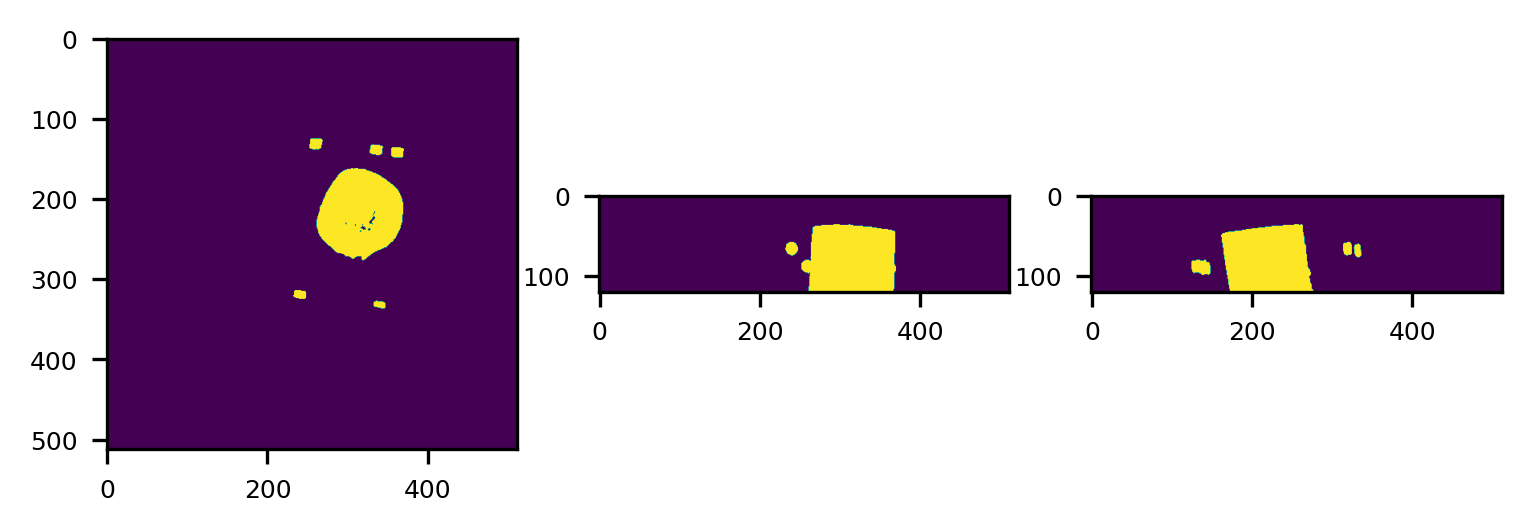

In [13]:
ru.plot_projections(data_3D_QCT_BW[0:120,:,:])
plt.show()

#### Calculate markers coordinates
- QCT dataset:

In [17]:
markers_coordinates = markers_coors(data_3D_QCT_BW[0:120,:,:]) # [z, y, x]
# multiply by voxelsize and flip
markers_coordinates = np.fliplr(markers_coordinates*vs_QCT) # [x, y, z]
print(markers_coordinates)

[[105.82608471  41.55939576  27.14610941]
 [ 76.06219041  38.40499819  26.35647309]
 [ 70.25120409  93.50069235  19.73675316]
 [ 99.37972134  97.17195701  20.42490844]
 [ 98.06171956  40.61632086  26.52902171]]


- HR-pQCT dataset:

In [18]:
markers_coordinates_HR = markers_coors(data_3D_BW) # [z, y, x]
# multiply by voxelsize and flip
markers_coordinates_HR = np.fliplr(markers_coordinates_HR*vs) # [x, y, z]
print(markers_coordinates_HR)

[[ 95.14473492 101.32866983  14.13808076]
 [ 97.73270739  71.42278125  13.96138494]
 [ 41.60149698  66.58067775  13.84548791]
 [ 38.80502449  96.19050367  14.01047265]
 [ 95.92570823  93.45705717  13.65874421]]


###  Alignment and registration rotation matrices
get n12, n14, v12, and v14 vectors

In [19]:
n12 = markers_coordinates[1,:] - markers_coordinates[0,:]
n14 = markers_coordinates[3,:] - markers_coordinates[0,:]

v12 = markers_coordinates_HR[1,:] - markers_coordinates_HR[0,:]
v14 = markers_coordinates_HR[3,:] - markers_coordinates_HR[0,:]

#### Rotation matrix to allign QCT markers with X-Y plane

In [20]:
R_xy = align_with_XYplane(n12, n14)
print(R_xy)

Angle between n12 and n14: 89.26177259047803 deg
[[ 0.99266487  0.11815851  0.02559349]
 [-0.11432369  0.98626668 -0.11919783]
 [-0.03932625  0.11539756  0.9925406 ]]


#### Rotation matrix to allign QCT markers with HR-pQCT markers

In [22]:
R_HR = align_with_vectors(n12, n14, v12, v14)
print(R_HR)

Angle between n12 and n14: 89.26177259047803 deg
Angle between v12 and v14: 89.7341963392544 deg
[[ 0.02375299 -0.9931241   0.11463123]
 [ 0.99914714  0.02745678  0.03084027]
 [-0.03377562  0.11380092  0.99292928]]


In [7]:
R_HR = [[0.02375299, -0.9931241, 0.11463123],
        [0.99914714,  0.02745678, 0.03084027],
        [-0.03377562, 0.11380092, 0.99292928]]

In [82]:
np.save(work_folder + '/Data/TacoSound/QCT/QCTFEMUR_2019L/R_HR_res10.npy', R_HR)

additional 180deg rotation fot STANCE LEFT samples

In [104]:
R_z180 = np.array([[-1.0, 0.0, 0.0],
                   [0.0, -1.0, 0.0],
                   [0.0, 0.0, 1.0]])

In [118]:
# one test 15 deg rotation matrix around Z-axis
theta = 15 # [deg]
theta = -np.pi * theta / 180
R_1rot = np.array([[np.cos(theta), -np.sin(theta), 0.0],
                   [np.sin(theta), np.cos(theta), 0.0],
                   [0.0, 0.0, 1.0]])

In [114]:
# R_xy2 = np.matmul(R_z180, R_xy)

### Apply affine transformation to QCT stack
Convert ndarray image to ITK image

In [23]:
img = sitk.GetImageFromArray(data_3D_QCT[0:120,:,:])

In [56]:
img.SetSpacing(np.flip(vs_QCT))

In [73]:
np.array(img.GetSize())/2 * img.GetSpacing()

array([75.008, 75.008, 18.03 ])

In [57]:
print(img)

Image (0x556fde0a3ff0)
  RTTI typeinfo:   itk::Image<unsigned short, 3u>
  Reference Count: 1
  Modified Time: 1970
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 0
  UpdateMTime: 0
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 120]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 120]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 34, 120]
  Spacing: [0.293, 0.293, 0.3005]
  Origin: [0, 0, 0]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.293 0 0
0 0.293 0
0 0 0.3005

  PointToIndexMatrix: 
3.41297 0 0
0 3.41297 0
0 0 3.32779

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x556fde0a2960)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, unsigned short>
      Refere

Define 3D affine transform

In [24]:
affine = sitk.AffineTransform(img.GetDimension())

#### Transform dataset - align with X-Y plane

In [ ]:
img_trans = affine_trans(img, transform=affine, tmatrix=R_xy)

#### Transform dataset - align with HR-pQCT dataset

In [75]:
img_trans = affine_trans(img, transform=affine, tmatrix=R_HR)

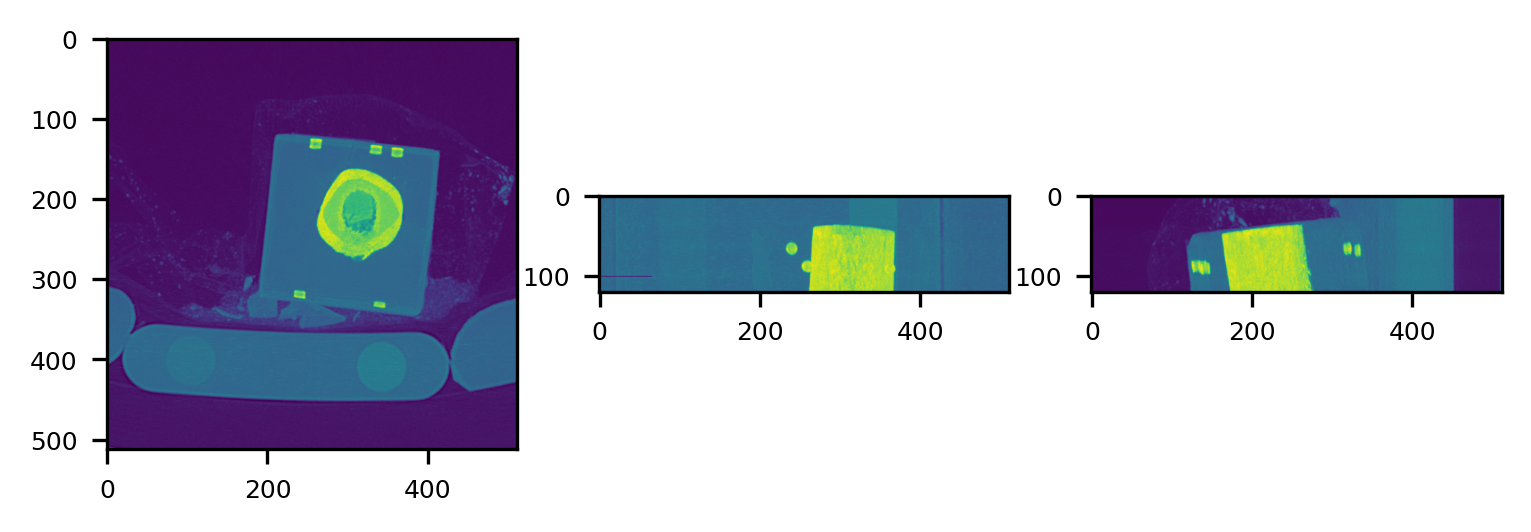

In [76]:
ru.plot_projections(data_3D_QCT[0:120,:,:])

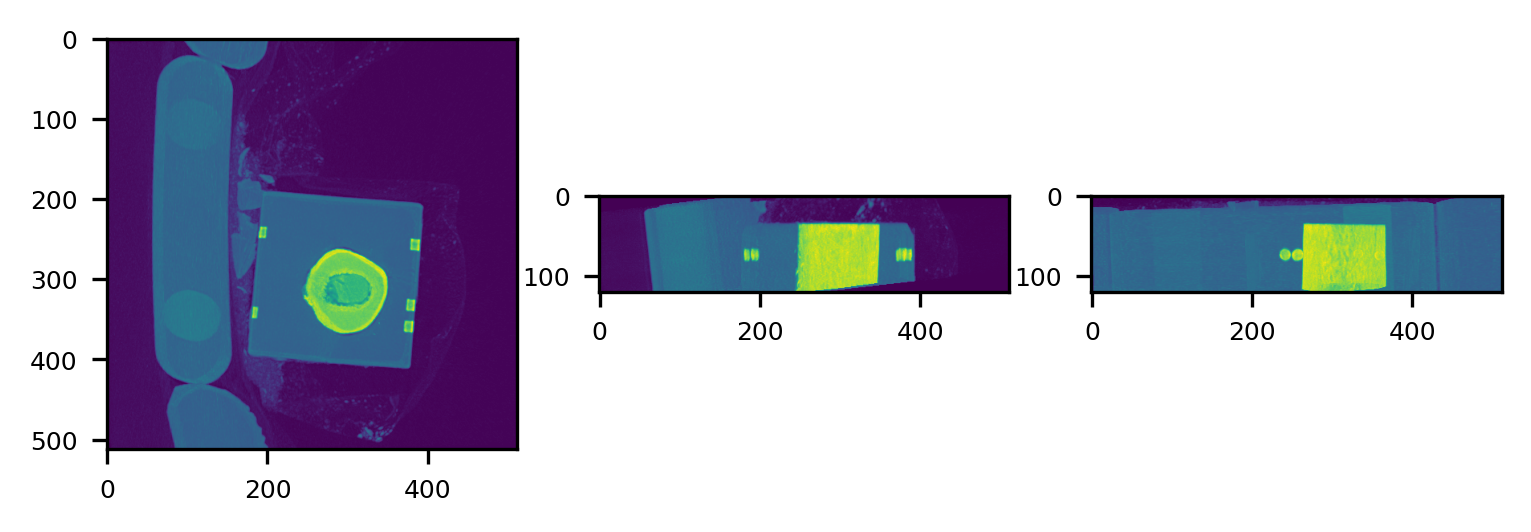

In [77]:
ru.plot_projections(sitk.GetArrayFromImage(img_trans))

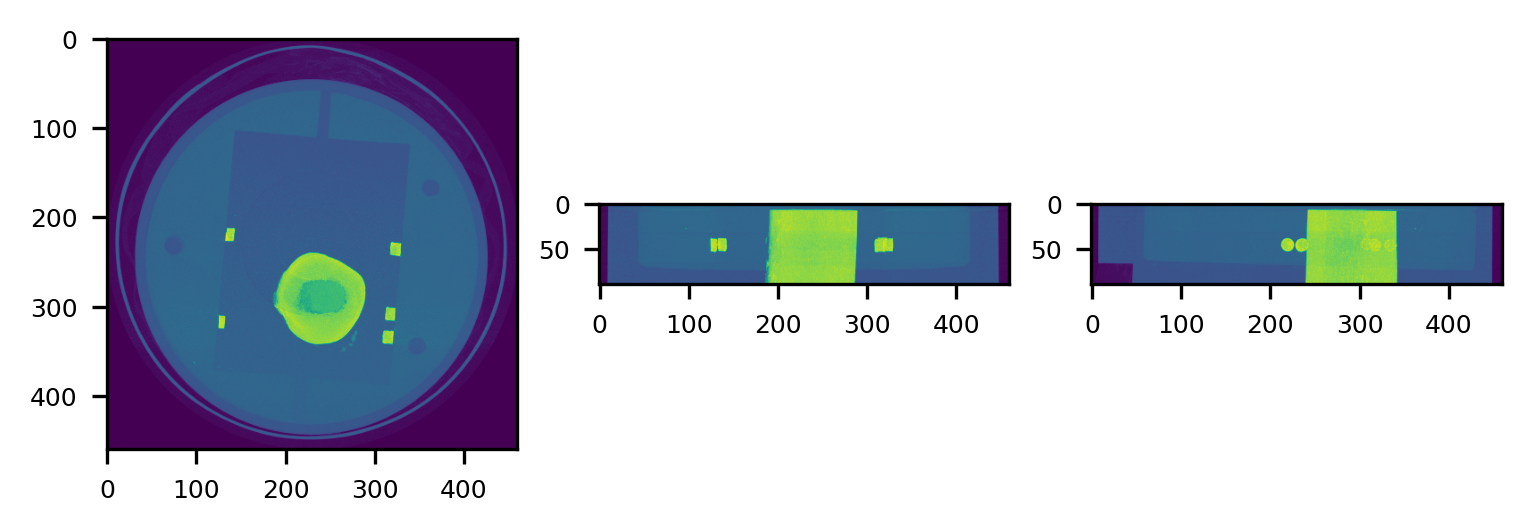

In [79]:
ru.plot_projections(data_3D[0:90,:,:])

Reload R_HR transformation matrix

In [83]:
# R_HR = np.load(work_folder + '/Data/TacoSound/QCT/QCTFEMUR_2019L/R_HR_res10.npy')

In [96]:
# import pygalmesh

## Bone compartments masks
### Whole bone mask (periosteum mask)

In [26]:
data_3D_BW_peri = periosteummask(data_3D>(ts_HR[1]-1000), closepixels=10, closevoxels=10, remove_objects_smaller_than=1, removeunconn=True, verbose=True)

INFO:root:Preliminary removal of objects smaller than 1 pixels.
INFO:root:2D slice-wise image closing and filling.
 Structuring element DISK of radius: 10
100%|██████████| 567/567 [00:48<00:00, 11.80it/s]
INFO:root:Removing isolated clusters of voxels.
INFO:root:Final 3D image closing.
 Structuring element CUBE of radius: 10


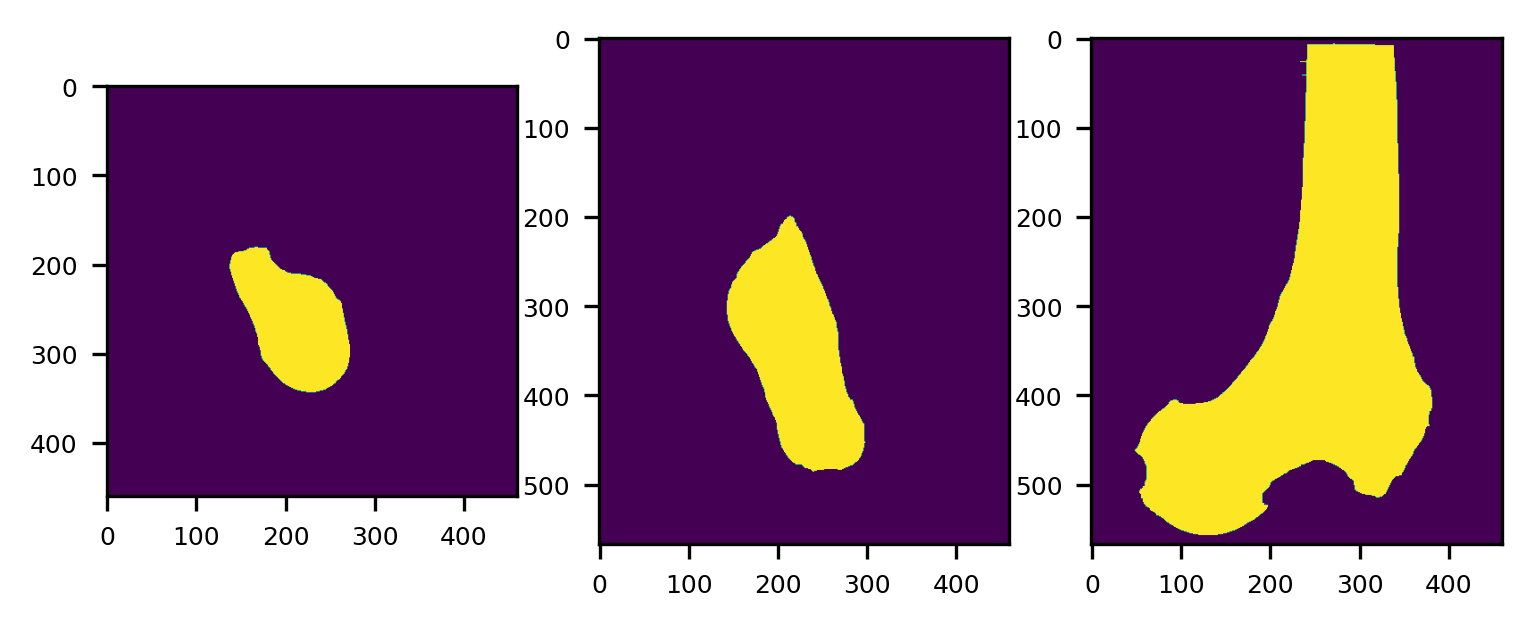

In [28]:
# ru.plot_midplanes(data_3D>(ts_HR[1]-1000))
ru.plot_midplanes(data_3D_BW_peri)

Write whole bone mask

In [6]:
perimask_file_HR = work_folder + '/Data/TacoSound/XtremeCT-II/00_resampled_data/2019_L/masks/periosteum/slice.tiff'

In [29]:
dxchange.writer.write_tiff_stack(data_3D_BW_peri, perimask_file_HR, axis=0, digit=4, start=0, overwrite=True)

Reload whole bone mask

In [14]:
data_3D_BW_peri = ru.read_tiff_stack(perimask_file_HR)
vs = [0.303, 0.303, 0.303] # [Z, Y, X][mm]

### Trabecular bone mask
We erode the whole bone mask to obtain a tentative mesh of the trabecular core

In [8]:
data_3D_BW_trab = morphology.binary_erosion(data_3D_BW_peri, morphology.cube(15))

Delete shaft portion from mask: this is done to remove thin struts and facilitate meshing

In [ ]:
data_3D_BW_trab[0:20, :, :] == 0

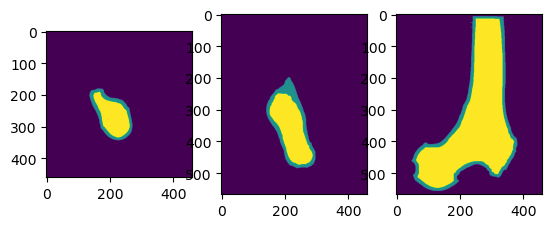

In [9]:
ru.plot_midplanes(data_3D_BW_trab.astype('int')+data_3D_BW_peri.astype('int'))

## Mesh of trabecular core
Create tetrahedra mesh of trabecular core: volume meshing is done using [CGAL](https://www.cgal.org/) through [pygalmesh](https://github.com/nschloe/pygalmesh)

In [11]:
import pygalmesh

In [35]:
# min_facet_angle=20,  lloyd=True,
size_f = 8 # size factor
mesh_trab = pygalmesh.generate_from_array(np.transpose(data_3D_BW_trab, [2, 1, 0]).astype('uint8'),
                                          tuple(vs),
                                          max_facet_distance=size_f*min(vs),
                                          max_cell_circumradius=3*size_f*min(vs)
                                         )

In [36]:
mesh_trab

<meshio mesh object>
  Number of points: 482
  Number of cells:
    triangle: 1372
    tetra: 1717
  Point data: medit:ref
  Cell data: medit:ref

Remove triangles

In [37]:
mesh_trab.remove_lower_dimensional_cells()

{'triangle'}

Write VTK mesh with [meshio](https://github.com/nschloe/meshio)

In [8]:
filename_mesh_out = work_folder + '/Data/TacoSound/XtremeCT-II/00_resampled_data/2019_L/masks/trabecular_coarse.vtk'

In [55]:
mesh_trab.write(filename_mesh_out)

Reload the mesh (if you have already generated it and want to start the notebook from this point)

In [9]:
import meshio
mesh_trab = meshio.read(filename_mesh_out)

### Get Barycenter of each cell (HR-pQCT data)

In [10]:
# cells barycenter coordinates
cells_bary = np.sum(mesh_trab.points[mesh_trab.cells[0][1][:]], 1)/mesh_trab.points[mesh_trab.cells[0][1][:]].shape[1]

In [9]:
filename_barycenters = work_folder + '/Data/TacoSound/XtremeCT-II/00_resampled_data/2019_L/masks/trabecular_coarse_barycenters.npy'

Save array of cells barycenters coordinates

In [13]:
np.save(filename_barycenters, cells_bary)

Reload it

In [10]:
cells_bary = np.load(filename_barycenters)

### Get cells barycenters on QCT data

In [69]:
cells_bary_tr = np.transpose(np.matmul(R_HR, np.transpose(cells_bary)))

Use marker 5 coordinates to get offset between HR-pQCT and transformed QCT ref systems (rigid translatio)

In [70]:
M5_coors_QCT = np.array([105.82608471, 41.55939576, 27.14610941])

In [71]:
M5_coors = np.array([95.14473492, 101.32866983, 14.13808076])

In [72]:
M5_coors_tr = np.matmul(M5_coors, R_HR)

In [73]:
offset = M5_coors_QCT-M5_coors_tr

Transform barycenter coordinates into QCT ref system

In [78]:
cells_bary_tr = np.matmul(cells_bary, R_HR) + offset

## Fabric worm
Extract fabric tensor at cells barycenters
### HR-pQCT data
> Run this section on high-resolution data!

| ver | runtime |
|-----|---------|
| `to01(ROIACF)>ACF_threshold` | 04:38<00:00, 51.14it/s |
| `envelope(to01andbinary(ROIACF, ACF_threshold))` | 04:15<00:00, 55.66it/s |

In [116]:
# pyfabric ACF parameters for HR-pQCT (0.303 mm)
ROIsize = 20
ACF_threshold=0.33
ROIzoom=True
zoom_size=14
zoom_factor=2

In [117]:
evecs, radii, evals, fabric_comp, DA = pyfabric.fabric_pointset(data_3D,
                                                                cells_bary/vs,
                                                                ROIsize,
                                                                ACF_threshold,
                                                                ROIzoom,
                                                                zoom_size,
                                                                zoom_factor)

100%|██████████| 1717/1717 [00:15<00:00, 114.10it/s]


### QCT data

In [118]:
# pyfabric ACF parameters for QCT (0.303 mm)
ROIsize = 20
ACF_threshold=0.33
ROIzoom=True
zoom_size=14
zoom_factor=2

In [119]:
evecs_QCT, radii_QCT, evals_QCT, fabric_comp_QCT, DA_QCT = pyfabric.fabric_pointset(data_3D_QCT, 
                                                                                    cells_bary_tr/vs_QCT,
                                                                                    ROIsize,
                                                                                    ACF_threshold,
                                                                                    ROIzoom,
                                                                                    zoom_size,
                                                                                    zoom_factor)

100%|██████████| 1717/1717 [00:20<00:00, 84.01it/s]


### Comparison

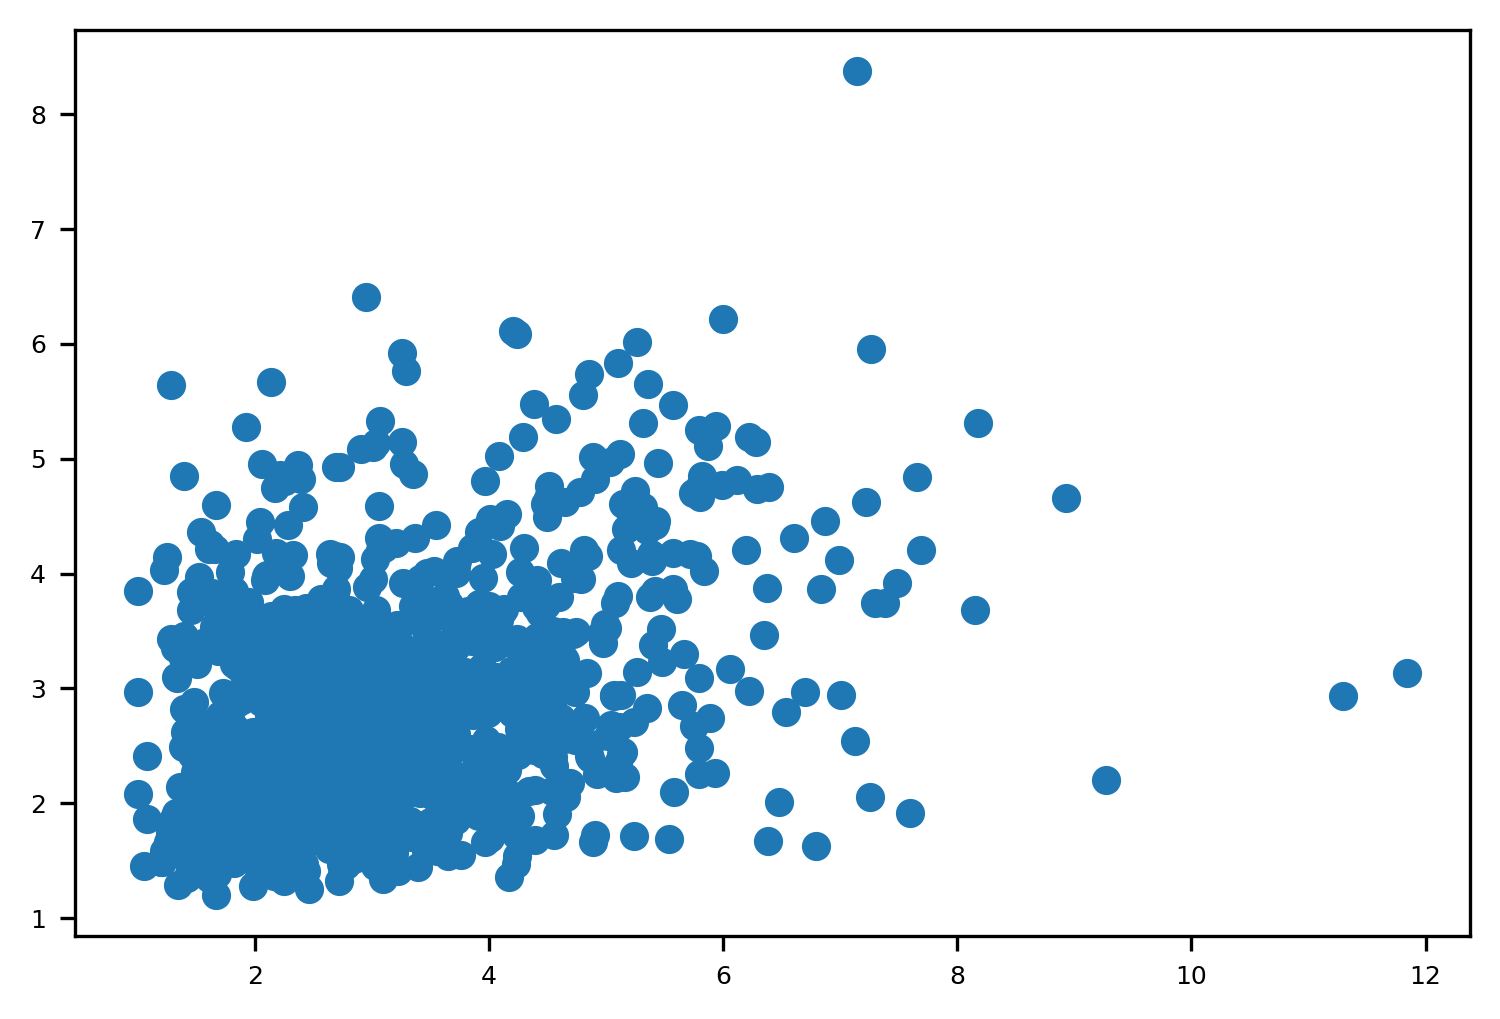

In [120]:
# plt.scatter(radii[:,2], radii_QCT[:,2], label='r3')
plt.scatter(DA, DA_QCT, label='DA')
plt.show()

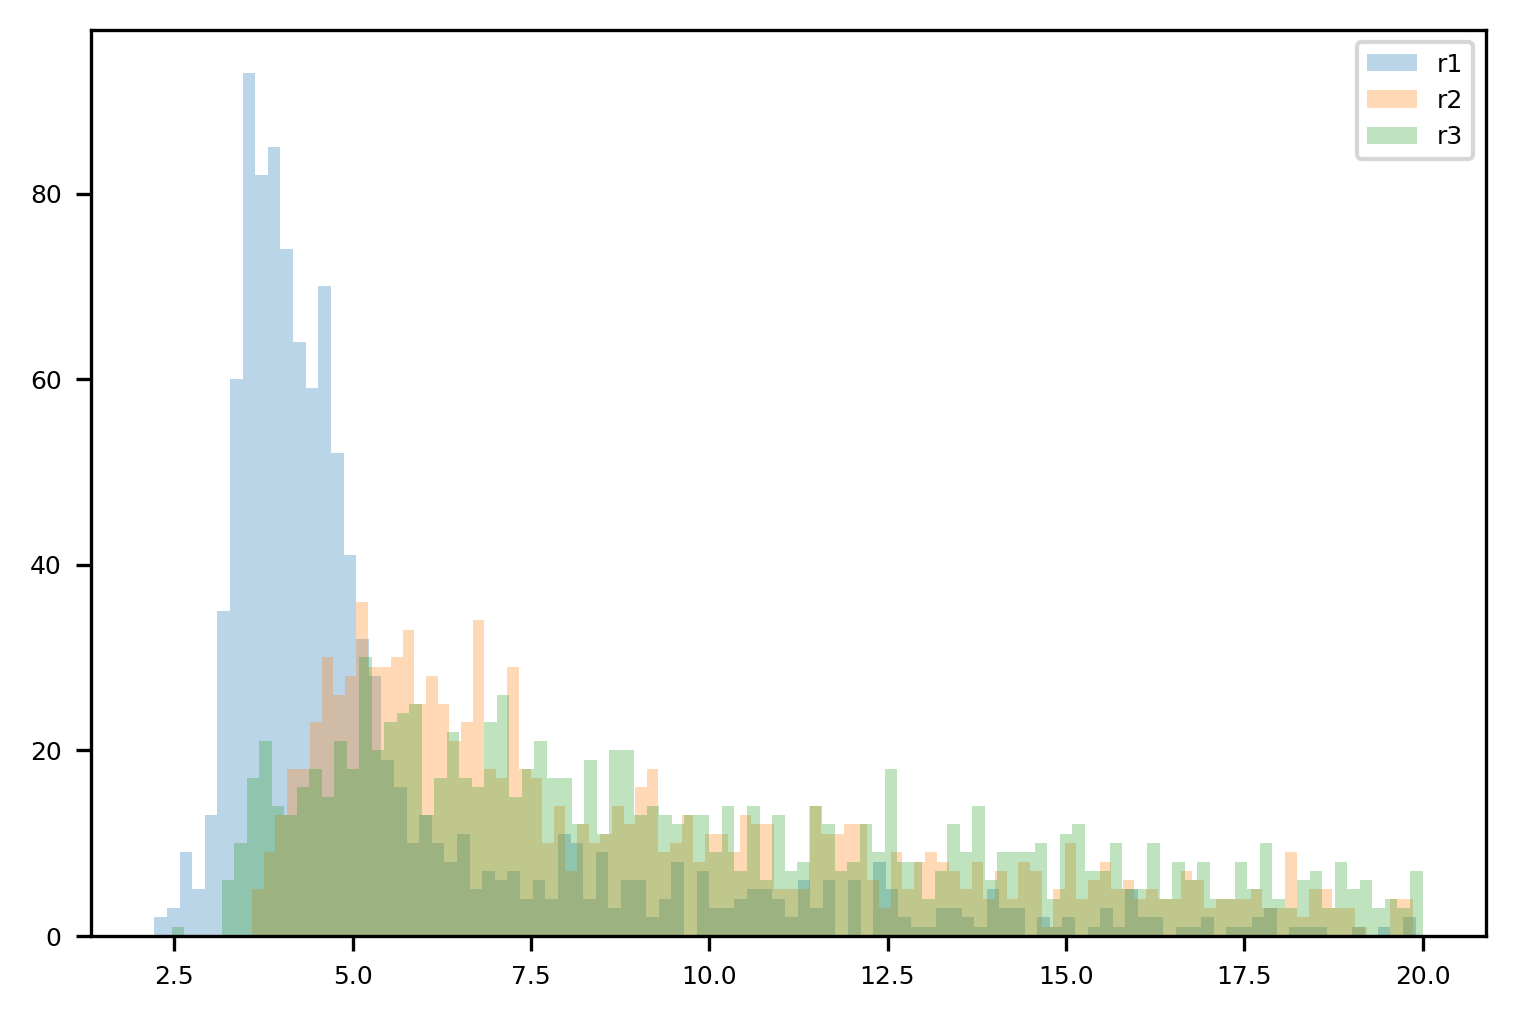

In [121]:
fig2, ax2 = plt.subplots()

plt.hist(radii_QCT[:,0].ravel(), alpha=0.3, bins=100, label='r1')
plt.hist(radii_QCT[:,1].ravel(), alpha=0.3, bins=100, label='r2')
plt.hist(radii_QCT[:,2].ravel(), alpha=0.3, bins=100, label='r3')
# plt.hist(radii.ravel(), alpha=0.4, bins=100)
plt.legend(loc='upper right')
plt.show()

In [ ]:
cell = 400

In [125]:
np.round((cells_bary[400,:]/vs)-ROIsize/2).astype('int')

array([210, 240, 435])

In [107]:
cells_bary_tr[400,:]/vs_QCT

array([250.84133768, 283.08992009, 487.80425491])

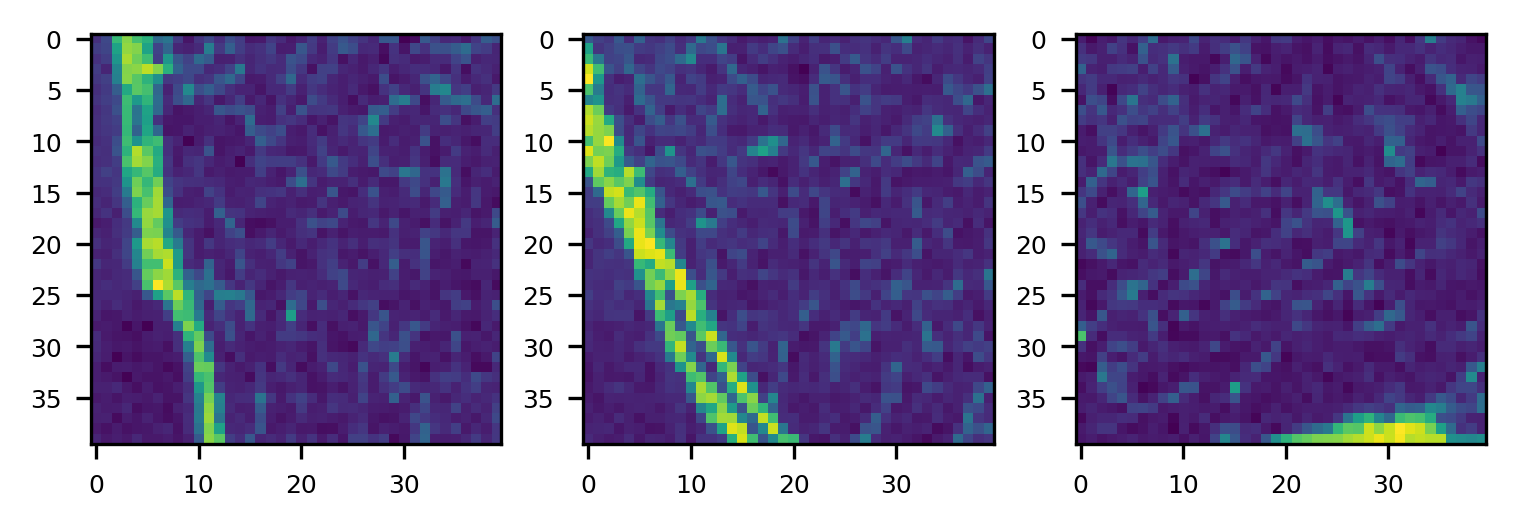

In [115]:
ru.plot_midplanes(data_3D[425:465, 229:269, 199:239])

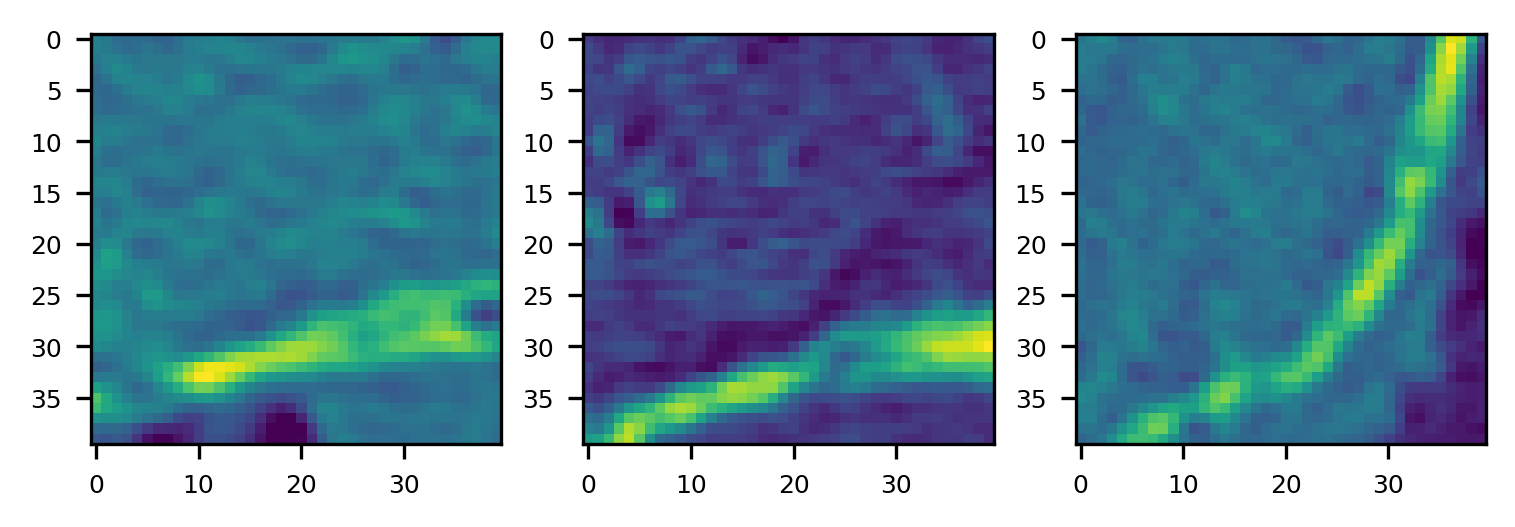

In [114]:
ru.plot_midplanes(data_3D_QCT[467:507, 263:303, 230:270])

---
# scratch:

In [16]:
np.matmul(cells_bary[0,:], R_HR)

array([ 67.54942104, -57.76803318,  95.46131422])

In [17]:
cells_bary[0,:]

array([69.918175, 68.84974 , 85.930756], dtype=float32)

Marker 3, 5 coordinates

In [46]:
M5_coors_QCT = np.array([105.82608471, 41.55939576, 27.14610941])

In [47]:
M5_coors = np.array([95.14473492, 101.32866983, 14.13808076])

In [48]:
M3_coors_QCT = np.array([99.37972134, 97.17195701, 20.42490844])

In [49]:
M3_coors = np.array([38.80502449, 96.19050367, 14.01047265])

Transform to HR-pQCT ref system and get offset (translation)

In [50]:
M5_coors_QCT_tr = np.matmul(R_HR, M5_coors_QCT)

In [51]:
offset = M5_coors-M5_coors_QCT_tr

In [52]:
offset

array([130.79289459,  -6.38544058, -13.97124196])

In [53]:
M5_coors

array([ 95.14473492, 101.32866983,  14.13808076])

In [54]:
M5_coors_QCT_tr+offset

array([ 95.14473492, 101.32866983,  14.13808076])

Check on M3 coordinates

In [55]:
M3_coors_QCT_tr = np.matmul(R_HR, M3_coors_QCT)

In [56]:
M3_coors

array([38.80502449, 96.19050367, 14.01047265])

In [57]:
M3_coors_QCT_tr+offset

array([38.99098014, 96.20746251, 14.01089407])

Check:
- [X] matmul order (OK)
- [X] offset dir (NO)
- [ ] matmul invert

Now do the opposite: HR-pQCT coordinates to QCT

In [72]:
M5_coors_tr = np.matmul(M5_coors, R_HR)

In [73]:
offset = M5_coors_QCT-M5_coors_tr

Check on M3 coordinates

In [74]:
M3_coors_tr = np.matmul(M3_coors, R_HR)

In [75]:
M3_coors_QCT

array([99.37972134, 97.17195701, 20.42490844])

In [76]:
M3_coors_tr+offset

array([99.35837415, 97.35612056, 20.40265085])

In [42]:
print((np.matmul(cells_bary[0,:], R_HR)))

[ 67.54942104 -57.76803318  95.46131422]


In [54]:
print((np.matmul(M5_coors, R_HR)+offset))

[ 92.34335036 -30.33016957  15.06164723]


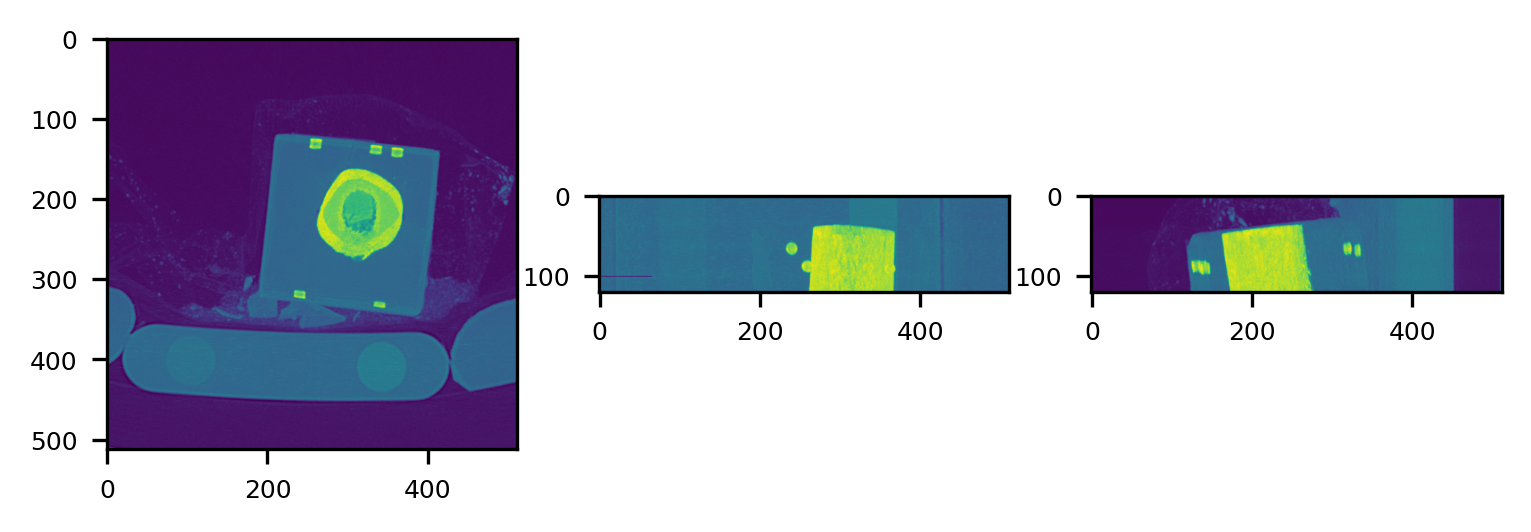

In [45]:
ru.plot_projections(data_3D_QCT[0:120,:,:])

M5_coors_QCT ~= 335, 140, 90